In [1]:
%matplotlib inline
# %matplotlib widget # for interactive figures

In [2]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

### Reload the line

In [3]:
line = xt.load('pimms_00_optics.json')

Loading line from dict:   0%|          | 0/99 [00:00<?, ?it/s]

Done loading line from dict.           


### Activate extraction sextupoles

In [4]:
line['kse1'] = 1
line['kse2'] = -6.5

### Analysis from the previous notebook moved into a function:

/Users/giadarol/xsuite_packages/xtrack/xtrack/twiss.py:3942: RuntimeWarning: invalid value encountered in divide
  pzeta = ctx2np(particles.ptau)[mask_at_ele]/ctx2np(particles.beta0)[mask_at_ele],


{'dpx_dx_at_septum': np.float64(-0.034276209139576824),
 'stable_area': np.float64(6.488570642404422e-05),
 'x_fp': array([-0.01049043, -0.004407  ,  0.01401398]),
 'px_fp': array([-0.01049043, -0.004407  ,  0.01401398]),
 'x_norm_fp': array([-0.0035705 , -0.00149993,  0.00476986]),
 'px_norm_fp': array([-0.0035705 , -0.00149993,  0.00476986])}

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


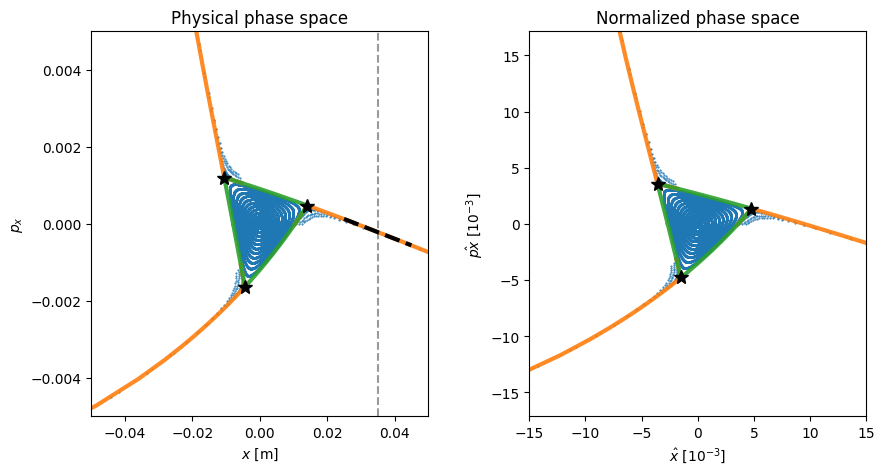

In [5]:
from phase_space_characterization import characterize_phase_space_at_septum
characterize_phase_space_at_septum(line, plot=True)

In [6]:
# Time the chracterization function (with no plot)
%time res = characterize_phase_space_at_septum(line)

CPU times: user 259 ms, sys: 4.47 ms, total: 264 ms
Wall time: 263 ms


## Resonance optimization

In [7]:
# To use the results from our function in an optimization
# we need to wrap the function in an Action class

# Define action class
class ActionSeparatrix(xt.Action):
    
    def __init__(self, line):
        self.line = line
        
    def run(self):
        out = characterize_phase_space_at_septum(self.line)
        return out
    
# Build action object
action = ActionSeparatrix(line)

In [8]:
# Test the action
action.run()

{'dpx_dx_at_septum': np.float64(-0.034276209139576824),
 'stable_area': np.float64(6.488570642404422e-05),
 'x_fp': array([-0.01049043, -0.004407  ,  0.01401398]),
 'px_fp': array([-0.01049043, -0.004407  ,  0.01401398]),
 'x_norm_fp': array([-0.0035705 , -0.00149993,  0.00476986]),
 'px_norm_fp': array([-0.0035705 , -0.00149993,  0.00476986])}

In [9]:
# From the action we can create optimization targets
# (we want to control the orientation of the saparatrix
#  and the size of the stable area) 
opt = line.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(['kse1', 'kse2'], step=0.5, limits=[-7, 7]),
    targets=[
        action.target('stable_area', 1.e-4, tol=1e-5, weight=100), 
        action.target('dpx_dx_at_septum', 0.03, tol=5e-4)
    ]
)

In [10]:
# Inspect state before optimization
opt.target_status()

Target status:               alty = 6.4372e-02              
id state tag              tol_met       residue   current_val    target_val description                                 
0  ON    stable_area        False  -3.51143e-05   6.48857e-05        0.0001 'stable_area', val=0.0001, tol=1e-05, we ...
1  ON    dpx_dx_at_septum   False    -0.0642762    -0.0342762          0.03 'dpx_dx_at_septum', val=0.03, tol=0.0005 ...


### How to use an external python optimizer

We could get the solution simply calling `opt.solve()` which uses the Xsuite internal optimizer.

For some problems you might want to use a different optimizer (e.g. a derivative-free one) because it is more suited to your problem. For example here we show how to apply the [Py-BOBYQA optimizer](https://numericalalgorithmsgroup.github.io/pybobyqa/build/html/index.html) to our non-linear match problem.

In [11]:
# We extract a the merit function from our Xsuite optimizer objects
merit_function = opt.get_merit_function(
        return_scalar=True, # Py-BOBYQA wants a scalar merit function
        check_limits=False) # Py-BOBYQA wants to explore a bit outside the enforced limits

In [12]:
# Extract limits and starting point from merit function
bounds = merit_function.get_x_limits()
x0 = merit_function.get_x()

In [13]:
# Search optimum using Py-BOBYQA
import pybobyqa
soln = pybobyqa.solve(merit_function, x0=x0,
            bounds=bounds.T, # wants them transposed...
            rhobeg=5, rhoend=1e-4, maxfun=30,
            objfun_has_noise=True, # <-- helps in this case
            seek_global_minimum=True)
soln.x

Matching: model call n. 31 penalty = 3.8933e-04              

array([4.89704752, 0.23152265])

In [14]:
# Set found solution in the line
merit_function.set_x(soln.x)

Matching: model call n. 32 penalty = 2.3014e-04              

In [15]:
# Status after optimization
opt.target_status()
opt.vary_status()

Target status:               nalty = 2.3014e-04              
id state tag              tol_met       residue   current_val    target_val description                                 
0  ON    stable_area         True  -4.08029e-07    9.9592e-05        0.0001 'stable_area', val=0.0001, tol=1e-05, we ...
1  ON    dpx_dx_at_septum    True  -0.000226492     0.0297735          0.03 'dpx_dx_at_septum', val=0.03, tol=0.0005 ...
Vary status:                 
id state tag met name lower_limit   current_val upper_limit val_at_iter_0          step        weight
0  ON        OK  kse1          -7       4.89705           7             1           0.5             1
1  ON        OK  kse2          -7      0.231523           7          -6.5           0.5             1


In [16]:
# Log solution in Xsuite optimizer log
opt.tag('bobyqa solution')
# Inspect the log
opt.log()

Matching: model call n. 34 penalty = 2.3014e-04              

Table: 2 rows, 16 cols
iteration                   penalty alpha tag             tol_met target_active hit_limits ...
0                         0.0643721    -1                 nn      yy            nn        
1                       0.000230138    -1 bobyqa solution yy      yy            nn        

{'dpx_dx_at_septum': np.float64(0.029773507843346488),
 'stable_area': np.float64(9.959197077004898e-05),
 'x_fp': array([ 0.01243504, -0.01749483,  0.00647458]),
 'px_fp': array([ 0.01243504, -0.01749483,  0.00647458]),
 'x_norm_fp': array([ 0.00423247, -0.00595454,  0.00220375]),
 'px_norm_fp': array([ 0.00423247, -0.00595454,  0.00220375])}

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


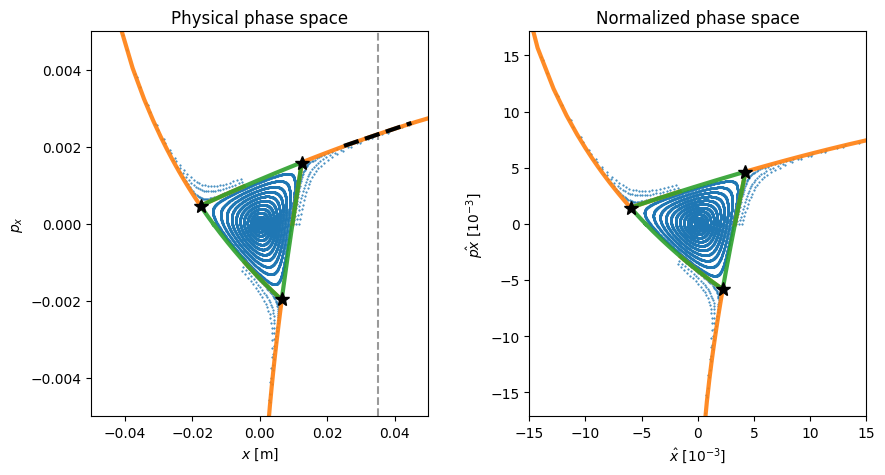

In [17]:
# Visualize phase space after optimization
characterize_phase_space_at_septum(line, plot=True)

## Reload points from the optimization log

In [18]:
opt.log()

Table: 2 rows, 16 cols
iteration                   penalty alpha tag             tol_met target_active hit_limits ...
0                         0.0643721    -1                 nn      yy            nn        
1                       0.000230138    -1 bobyqa solution yy      yy            nn        

In [19]:
# Reload initial point
opt.reload(0)

Matching: model call n. 35 penalty = 6.4372e-02              

In [20]:
opt.vary_status()

Vary status:                 
id state tag met name lower_limit   current_val upper_limit val_at_iter_0          step        weight
0  ON        OK  kse1          -7             1           7             1           0.5             1
1  ON        OK  kse2          -7          -6.5           7          -6.5           0.5             1


{'dpx_dx_at_septum': np.float64(-0.034276209139576824),
 'stable_area': np.float64(6.488570642404422e-05),
 'x_fp': array([-0.01049043, -0.004407  ,  0.01401398]),
 'px_fp': array([-0.01049043, -0.004407  ,  0.01401398]),
 'x_norm_fp': array([-0.0035705 , -0.00149993,  0.00476986]),
 'px_norm_fp': array([-0.0035705 , -0.00149993,  0.00476986])}

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


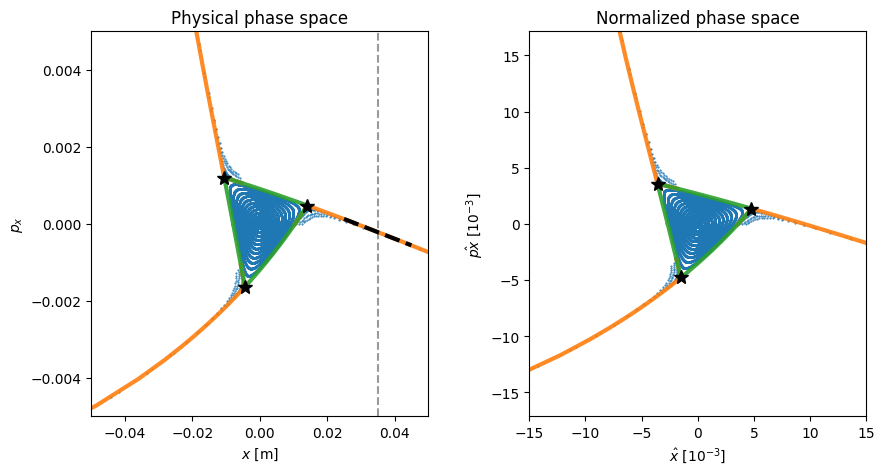

In [21]:
characterize_phase_space_at_septum(line, plot=True)

In [22]:
# Reload tagged point
opt.reload(tag='bobyqa solution')

Matching: model call n. 36 penalty = 2.3014e-04              

{'dpx_dx_at_septum': np.float64(0.029773507843346488),
 'stable_area': np.float64(9.959197077004898e-05),
 'x_fp': array([ 0.01243504, -0.01749483,  0.00647458]),
 'px_fp': array([ 0.01243504, -0.01749483,  0.00647458]),
 'x_norm_fp': array([ 0.00423247, -0.00595454,  0.00220375]),
 'px_norm_fp': array([ 0.00423247, -0.00595454,  0.00220375])}

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


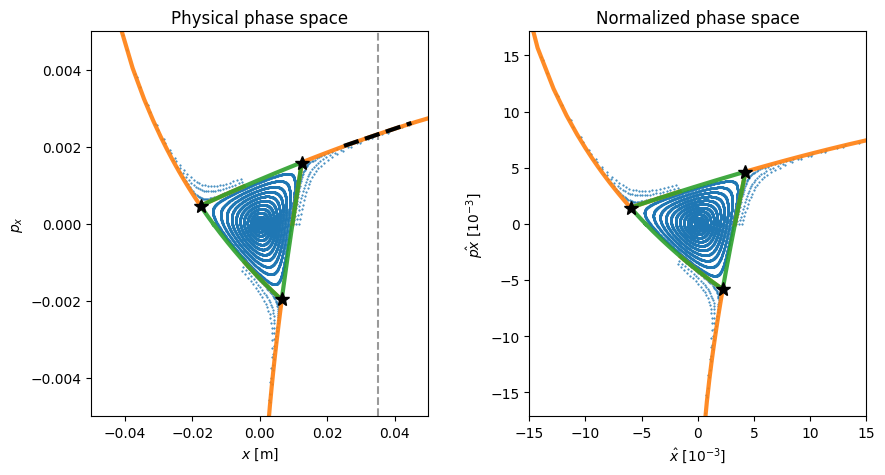

In [23]:
characterize_phase_space_at_septum(line, plot=True)

### Save line with tuned extraction

In [24]:
line.to_json('pimms_02_tuned.json')